**Pulling Data from Kalshi and NWS**

In [ ]:
import requests
from datetime import datetime, timedelta

# Latitude & Longitude for Austin Bergstrom Airport
LAT = 30.1975
LON = -97.6664

# NWS API Base URL
NWS_API_URL = f"https://api.weather.gov/points/{LAT},{LON}"

def get_tomorrows_forecast():
    """Fetches the weather forecast for tomorrow using NWS API."""
    response = requests.get(NWS_API_URL)
    if response.status_code == 200:
        forecast_url = response.json()["properties"]["forecast"]
        forecast_response = requests.get(forecast_url)

        if forecast_response.status_code == 200:
            periods = forecast_response.json()["properties"]["periods"]

            # Get tomorrow’s date
            tomorrow = (datetime.now() + timedelta(days=1)).date()

            for period in periods:
                if period["name"].startswith("Tomorrow"):
                    return period["temperature"], period["shortForecast"]

            # If "Tomorrow" is not explicitly listed, find by date
            for period in periods:
                if datetime.strptime(period["startTime"], "%Y-%m-%dT%H:%M:%S%z").date() == tomorrow:
                    return period["temperature"], period["shortForecast"]

    return None, "Could not retrieve forecast."

# Get tomorrow's temperature forecast
temp, forecast = get_tomorrows_forecast()
print(f"🌡️ Forecast for Tomorrow: {temp}°F - {forecast}")

🌡️ Forecast for Tomorrow: 76°F - Chance Showers And Thunderstorms then Mostly Sunny


In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import csv

def get_historical_forecasts(api_key, location, start_date_str, end_date_str):
    """
    Fetch historical forecasts for a location with specific date range
    Parameters:
    api_key (str): Your Visual Crossing API key
    location (str): Location name or coordinates
    start_date_str (str): Start date in YYYY-MM-DD format
    end_date_str (str): End date in YYYY-MM-DD format
    Returns:
    DataFrame: Historical forecast maximum temperature data
    """
    # Visual Crossing API endpoint
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{location}/{start_date_str}/{end_date_str}"
    # Parameters
    params = {
        'key': api_key,
        'include': 'fcst,obs',  # Include forecast and observed data
        'elements': 'datetime,tempmax',  # Only request maximum temperature
        'unitGroup': 'us',  # Use Fahrenheit
        'contentType': 'json',
    }
    print(f"Requesting data from: {url}")
    # Make request
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Extract the daily data
        daily_data = data.get('days', [])
        # Create list to store data
        forecast_data = []
        for day in daily_data:
            date = day.get('datetime')
            max_temp = day.get('tempmax')
            forecast_data.append({
                'date': date,
                'forecasted_max_temp': max_temp
            })
        # Convert to DataFrame
        df = pd.DataFrame(forecast_data)
        return df
    else:
        print(f"Error: {response.status_code}")
        print(f"Response text: {response.text}")
        return None

def split_date_range(start_date_str, end_date_str, chunk_days=180):
    """
    Split a date range into smaller chunks
    Parameters:
    start_date_str (str): Start date in YYYY-MM-DD format
    end_date_str (str): End date in YYYY-MM-DD format
    chunk_days (int): Number of days per chunk
    Returns:
    list: List of tuples containing (start_date, end_date) for each chunk
    """
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    date_ranges = []
    chunk_start = start_date

    while chunk_start <= end_date:
        chunk_end = chunk_start + timedelta(days=chunk_days - 1)
        if chunk_end > end_date:
            chunk_end = end_date

        date_ranges.append((
            chunk_start.strftime('%Y-%m-%d'),
            chunk_end.strftime('%Y-%m-%d')
        ))

        chunk_start = chunk_end + timedelta(days=1)

    return date_ranges

def save_to_csv(df, filename="austin_bergstrom_historical_forecast.csv", mode='w'):
    """
    Save the DataFrame to a CSV file
    Parameters:
    df (DataFrame): DataFrame containing the data
    filename (str): Name of the CSV file
    mode (str): 'w' for write (overwrite), 'a' for append
    """
    if df is not None:
        if mode == 'w':
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")
        else:  # append mode
            df.to_csv(filename, index=False, mode='a', header=False)
            print(f"Data appended to {filename}")
    else:
        print("No data to save")

# Example usage
if __name__ == "__main__":
    # Your API key
    API_KEY = "QNE7AGLLZTFG6W6MT53M2DHSJ"

    # Set specific date range
    START_DATE = "2020-01-01"
    END_DATE = "2025-02-28"  # Using a fixed end date of Feb 28, 2025

    # Split the date range into smaller chunks (180 days each)
    date_chunks = split_date_range(START_DATE, END_DATE, chunk_days=180)
    print(f"Split date range into {len(date_chunks)} chunks")

    # Location information
    LOCATION = "Austin-Bergstrom,TX,USA"  # Try this format first

    # Alternative options if the first one doesn't work
    alternative_locations = [
        "30.1975,-97.6664",  # Exact coordinates for Austin-Bergstrom
        "78719",             # Airport zip code
        "Austin,TX,USA"      # City name if airport doesn't work
    ]

    # Initialize an empty DataFrame to store all results
    all_data = pd.DataFrame()
    first_chunk = True

    # Process each date chunk
    for i, (chunk_start, chunk_end) in enumerate(date_chunks):
        print(f"\nProcessing chunk {i+1}/{len(date_chunks)}: {chunk_start} to {chunk_end}")

        # Try the main location first
        print(f"Trying location: {LOCATION}")
        historical_data = get_historical_forecasts(API_KEY, LOCATION, chunk_start, chunk_end)

        # If that fails, try alternatives
        if historical_data is None:
            for alt_location in alternative_locations:
                print(f"Trying alternative location: {alt_location}")
                historical_data = get_historical_forecasts(API_KEY, alt_location, chunk_start, chunk_end)
                if historical_data is not None:
                    print(f"Successfully retrieved data for {alt_location}")
                    break

        # Save or append to CSV depending on whether it's the first chunk
        if historical_data is not None:
            if first_chunk:
                save_to_csv(historical_data, mode='w')
                first_chunk = False
            else:
                save_to_csv(historical_data, mode='a')

        # Add a small delay between API calls to be nice to the server
        import time
        time.sleep(1)

    print("\nData collection complete. All chunks processed.")

Split date range into 11 chunks

Processing chunk 1/11: 2020-01-01 to 2020-06-28
Trying location: Austin-Bergstrom,TX,USA
Requesting data from: https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/Austin-Bergstrom,TX,USA/2020-01-01/2020-06-28
Error: 429
Response text: You have exceeded the maximum number of daily result records for your account. 
Trying alternative location: 30.1975,-97.6664
Requesting data from: https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/30.1975,-97.6664/2020-01-01/2020-06-28
Error: 429
Response text: You have exceeded the maximum number of daily result records for your account. 
Trying alternative location: 78719
Requesting data from: https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/78719/2020-01-01/2020-06-28
Error: 429
Response text: You have exceeded the maximum number of daily result records for your account. 
Trying alternative location: Austin,TX,USA
Reque

In [ ]:
import pandas as pd
import numpy as np

# Load the actual temperature data
actual_data = pd.read_csv("actual_max_temp.csv")

# Load the forecast data
forecast_data = pd.read_csv("forecast_max_temp.csv")

# Round forecasted temperatures to nearest integer
forecast_data['forecasted_max_temp_rounded'] = forecast_data['forecasted_max_temp'].round().astype(int)

# Rename columns for easier merging
actual_data = actual_data.rename(columns={
    'DATE': 'date',
    'TMAX': 'actual_max_temp'
})

# Convert the actual_max_temp column to numeric, handling missing values
actual_data['actual_max_temp'] = pd.to_numeric(actual_data['actual_max_temp'], errors='coerce')

# Merge the datasets on date
merged_data = pd.merge(forecast_data, actual_data[['date', 'actual_max_temp']], on='date', how='inner')

# Drop rows with missing actual temperatures
merged_data = merged_data.dropna(subset=['actual_max_temp'])

# Calculate the absolute difference between forecasted and actual temperatures
merged_data['temp_diff'] = abs(merged_data['forecasted_max_temp_rounded'] - merged_data['actual_max_temp'])

# Identify exactly correct forecasts (diff = 0)
merged_data['exactly_correct'] = merged_data['temp_diff'] == 0

# Identify forecasts that are exactly 1 degree off (diff = 1)
merged_data['off_by_one'] = merged_data['temp_diff'] == 1

# Calculate counts
total_forecasts = len(merged_data)
exactly_correct = merged_data['exactly_correct'].sum()
off_by_one = merged_data['off_by_one'].sum()

# Calculate proportions
exact_accuracy = exactly_correct / total_forecasts
off_by_one_ratio = off_by_one / total_forecasts
combined_accuracy = exact_accuracy + off_by_one_ratio

# Display simple summary results
print("SUMMARY OF FORECAST ACCURACY")
print("===========================")
print(f"Total number of forecasts analyzed: {total_forecasts}")
print("\nEXACT MATCHES:")
print(f"Number of exactly correct forecasts: {exactly_correct}")
print(f"Proportion of exactly correct forecasts: {exact_accuracy:.4f} ({exact_accuracy*100:.2f}%)")
print("\nOFF BY 1°F:")
print(f"Number of forecasts off by exactly 1°F: {off_by_one}")
print(f"Proportion of forecasts off by exactly 1°F: {off_by_one_ratio:.4f} ({off_by_one_ratio*100:.2f}%)")
print("\nCOMBINED (EXACT + OFF BY 1°F):")
print(f"Number of forecasts exact or off by 1°F: {exactly_correct + off_by_one}")
print(f"Proportion of forecasts exact or off by 1°F: {combined_accuracy:.4f} ({combined_accuracy*100:.2f}%)")

FileNotFoundError: [Errno 2] No such file or directory: 'actual_max_temp.csv'

65.205


100
100
110.0
104.5
110.0
110.0
121.0
121.0
133.1
133.1
139.0895
139.0895
139.0895
145.3485275
138.08110112499998
138.08110112499998
131.17704606874997
138.08110112499998
131.17704606874997
131.17704606874997
124.61819376531247
118.38728407704684
118.38728407704684
118.38728407704684
130.22601248475152
130.22601248475152
143.24861373322668
143.24861373322668
149.69480135122188
149.69480135122188
142.2100612836608
142.2100612836608
135.09955821947776
135.09955821947776
135.09955821947776
141.17903833935426
141.17903833935426
134.12008642238655
141.17903833935426
134.12008642238655
134.12008642238655
127.41408210126723
121.04337799620386
114.99120909639366
109.24164864157397
103.77956620949527
103.77956620949527
98.5905878990205
98.5905878990205
93.66105850406947
93.66105850406947
93.66105850406947
97.8758061367526
92.98201582991497
92.98201582991497
88.33291503841922
92.98201582991497
92.98201582991497
102.28021741290647
102.28021741290647
106.88282719648726
101.53868583666289
101.53868

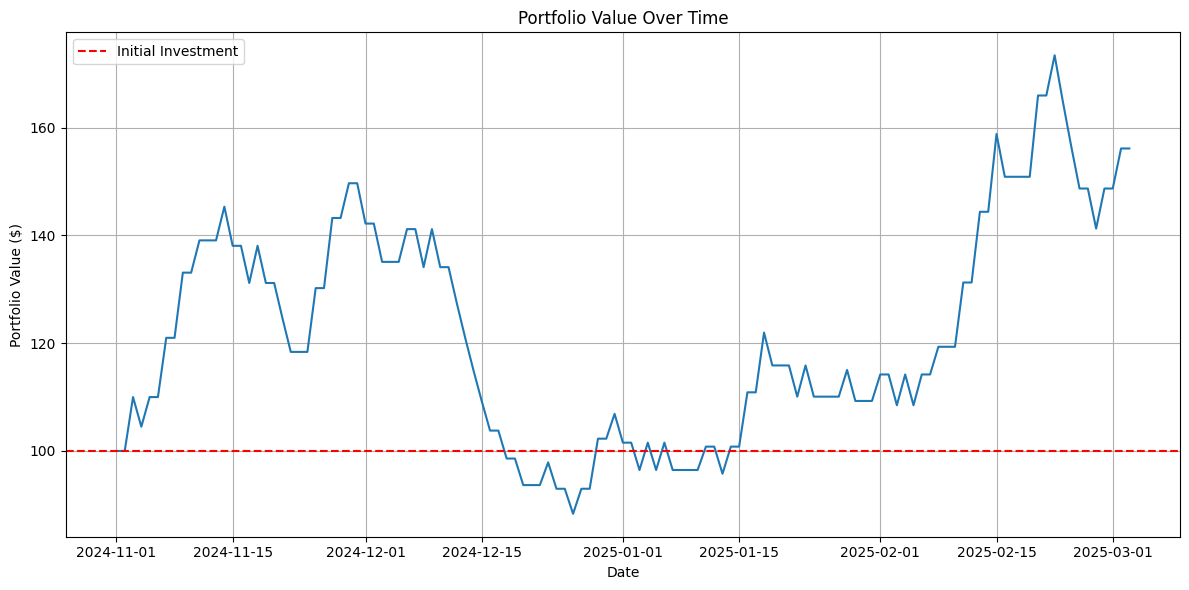

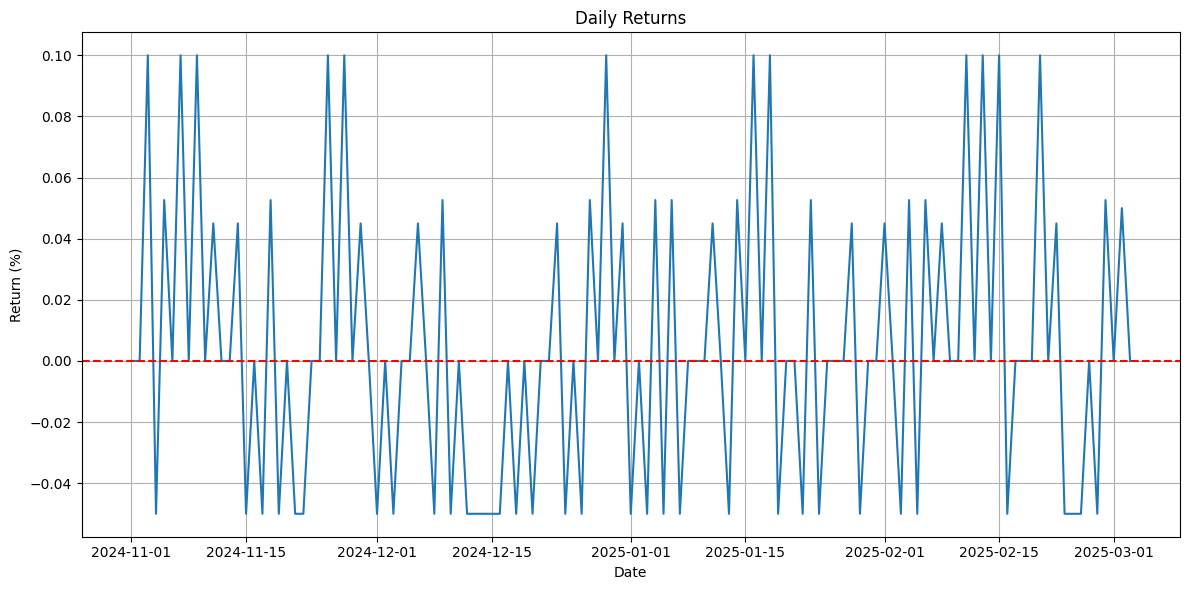

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data
forecast_data = pd.read_csv('trunc_forecast_max_temp.csv')
kalshi_data = pd.read_csv('filtered_kalshi_weather_data.csv')

# Parse dates
forecast_data['date'] = pd.to_datetime(forecast_data['date'])
kalshi_data['event_date'] = pd.to_datetime(kalshi_data['event_sub_title'].str.extract(r'On (.+)')[0], format='%b %d, %Y')

# Function to check if temperature falls within a range
def temp_in_range(temp, range_str):
    if '° or below' in range_str:
        upper = int(range_str.split('° or below')[0])
        return temp <= upper
    elif '° or above' in range_str:
        lower = int(range_str.split('° or above')[0])
        return temp >= lower
    elif 'to' in range_str:
        lower = int(range_str.split('° to ')[0])
        upper = int(range_str.split('to ')[1].split('°')[0])
        return lower <= temp <= upper
    return False

# Starting from November 1st, 2024
start_date = pd.Timestamp('2024-11-01')
forecast_data = forecast_data[forecast_data['date'] >= start_date].reset_index(drop=True)

# Prepare tracking variables
initial_capital = 100
available_capital = initial_capital
portfolio_value = initial_capital
portfolio_history = [portfolio_value]
dates = [start_date]
bet_history = []
wins = 0
losses = 0
waiting_profits = 0  # Track winnings waiting to be added to portfolio
days_since_win = 0   # Track days since last win
daily_returns = [0]  # Track daily returns for Sharpe ratio

# Dictionary to store correct temperature range for each day
correct_ranges = {}
for _, row in kalshi_data.iterrows():
    date = row['event_date']
    correct_ranges[date] = row['market_subtitle']

# Run the backtest
for _, row in forecast_data.iterrows():
    date = row['date']
    temp = row['forecasted_max_temp']

    # Store previous portfolio value for calculating daily return
    prev_portfolio_value = portfolio_value

    # Check if we should add waiting profits to available capital
    if waiting_profits > 0:
        days_since_win += 1
        if days_since_win >= 2:  # After 2 days, add waiting profits to available capital
            available_capital += waiting_profits
            portfolio_value += waiting_profits
            waiting_profits = 0
            days_since_win = 0

    # Skip if we don't have Kalshi data for this date
    if date not in correct_ranges:
        # Still record portfolio value for skipped dates
        portfolio_history.append(portfolio_value)
        dates.append(date)
        # Calculate daily return (0% if no change)
        daily_return = (portfolio_value / prev_portfolio_value) - 1 if prev_portfolio_value > 0 else 0
        daily_returns.append(daily_return)
        continue

    # Get the correct temperature range for this day
    correct_range = correct_ranges[date]

    # Calculate bet amount (Kelly %)
    bet_amount = min(available_capital * 0.05, 1500)

    # Check if our forecasted temperature falls within the correct range
    forecast_correct = temp_in_range(temp, correct_range)

    # Calculate outcome
    if forecast_correct:
        # Win: Double the bet amount
        profit = bet_amount  # (We get our bet back plus the same amount)
        waiting_profits += profit  # Add profit to waiting queue
        day_result = "win"
        wins += 1
    else:
        # Lose: Lose the entire bet
        profit = -bet_amount
        available_capital += profit  # Immediately reduce available capital
        portfolio_value += profit
        day_result = "lose"
        losses += 1

    # Record this bet
    bet_history.append({
        'date': date,
        'forecast_temp': temp,
        'correct_range': correct_range,
        'forecast_correct': forecast_correct,
        'bet_amount': bet_amount,
        'profit': profit,
        'waiting_profits': waiting_profits,
        'result': day_result,
        'portfolio_value': portfolio_value
    })

    # Record portfolio value for this date
    portfolio_history.append(portfolio_value)
    dates.append(date)

    # Calculate daily return
    daily_return = (portfolio_value / prev_portfolio_value) - 1 if prev_portfolio_value > 0 else 0
    daily_returns.append(daily_return)

    # Check for bankruptcy
    print(portfolio_value)
    if portfolio_value <= 1:
        print(f"Bankrupt on {date}")
        break

# Create results dataframe
results_df = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_history,
    'daily_return': daily_returns
})

# Calculate performance metrics
initial_value = portfolio_history[0]
final_value = portfolio_history[-1]
total_return = (final_value - initial_value) / initial_value * 100
num_trades = len(bet_history)
win_rate = (wins / num_trades * 100) if num_trades > 0 else 0

# Calculate Sharpe Ratio
# Assuming risk-free rate of 4% annually, which is approximately 0.011% daily
risk_free_rate_daily = 0.04 / 365
excess_returns = np.array(daily_returns[1:]) - risk_free_rate_daily  # Skip the first 0
sharpe_ratio_daily = np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) > 0 else 0
sharpe_ratio_annual = sharpe_ratio_daily * np.sqrt(365)  # Annualize

# Print results
print(f"Backtesting Results:")
print(f"Starting Portfolio: ${initial_value:,.2f}")
print(f"Final Portfolio: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2f}% ({wins} wins, {losses} losses)")
print(f"Daily Sharpe Ratio: {sharpe_ratio_daily:.4f}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual:.4f}")

if portfolio_value <= 0:
    print("Strategy went bankrupt during the testing period")

# Calculate max drawdown
portfolio_array = np.array(portfolio_history)
peak = np.maximum.accumulate(portfolio_array)
drawdown = (portfolio_array - peak) / peak * 100
max_drawdown = np.min(drawdown)
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Create a detailed bet history DataFrame
bet_df = pd.DataFrame(bet_history)

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_history)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.axhline(y=initial_value, color='r', linestyle='--', label='Initial Investment')
plt.legend()
plt.tight_layout()

# Plot daily returns
plt.figure(figsize=(12, 6))
plt.plot(dates[1:], daily_returns[1:])  # Skip the first day (no return)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()

# Find winning and losing days
if not bet_df.empty:
    # Periods of consecutive wins and losses
    bet_df['streak'] = (bet_df['result'] != bet_df['result'].shift(1)).cumsum()
    streaks = bet_df.groupby(['streak', 'result']).size().reset_index(name='count')
    max_win_streak = streaks[streaks['result'] == 'win']['count'].max() if not streaks[streaks['result'] == 'win'].empty else 0
    max_loss_streak = streaks[streaks['result'] == 'lose']['count'].max() if not streaks[streaks['result'] == 'lose'].empty else 0

    print(f"\nLongest Win Streak: {max_win_streak} days")
    print(f"Longest Loss Streak: {max_loss_streak} days")

    # Monthly performance
    bet_df['month'] = bet_df['date'].dt.to_period('M')
    monthly = bet_df.groupby('month').agg({
        'result': lambda x: sum(x == 'win'),
        'profit': 'sum',
        'portfolio_value': 'last'
    }).reset_index()

    print("\nMonthly Performance:")
    for _, row in monthly.iterrows():
        month_name = row['month'].strftime('%b %Y')
        wins_in_month = row['result']
        trades_in_month = len(bet_df[bet_df['month'] == row['month']])
        win_rate_month = (wins_in_month / trades_in_month * 100) if trades_in_month > 0 else 0
        month_profit = row['profit']

        print(f"{month_name}: Win Rate {win_rate_month:.1f}%, Portfolio: ${row['portfolio_value']:,.2f}, Profit: ${month_profit:,.2f}")

# Show first few losing trades
losing_trades = bet_df[bet_df['result'] == 'lose']
if not losing_trades.empty:
    print("\nLosing Trades:")
    for i, (_, trade) in enumerate(losing_trades.iterrows()):
        print(f"{i+1}. {trade['date'].strftime('%Y-%m-%d')}: Predicted {trade['forecast_temp']}°F, Correct Range was {trade['correct_range']}, Lost ${trade['bet_amount']:,.2f}")
        if i >= 4:  # Show at most 5 losing trades
            break

# Summary
print("\nStrategy Summary:")
if portfolio_value <= 0:
    print(f"Strategy went bankrupt after {len(bet_history)} trades on {dates[-1].strftime('%Y-%m-%d')}")
else:
    print(f"Starting with ${initial_value:,.2f} on {dates[0].strftime('%Y-%m-%d')}")
    print(f"Ending with ${final_value:,.2f} on {dates[-1].strftime('%Y-%m-%d')}")
    print(f"Total Return: {total_return:.2f}%")
    days_elapsed = (dates[-1] - dates[0]).days
    if days_elapsed > 0:
        annualized_return = ((final_value/initial_value) ** (365/days_elapsed) - 1) * 100
        print(f"Annualized Return: {annualized_return:.2f}%")
        print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual:.4f}")